
... ***CURRENTLY UNDER DEVELOPMENT*** ...


### TODO
- INTRODUCIR PLOTEO SCA_VAL EN RECONSTRUCCIONES SEA Y SWELL
- VALIDACION VS BOYA AWAC + PLOTEO
- MAL PLOTEO VALIDACION ANNUAL MAXIMA??


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Reconstruction, RBF_Validation
from teslakit.waves import Aggregate_WavesFamilies

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# input files: dataset, subset (MDA classification), and target (SWAN simulations output)

# sea 
wvs_sea_dataset_sim = db.Load_NEARSHORE_SIM_sea()
wvs_sea_dataset_hist = db.Load_NEARSHORE_HIST_sea()
wvs_sea_subset = db.Load_NEARSHORE_MDA_sea()
wvs_sea_target = db.Load_NEARSHORE_TARGET_sea()

# swells 
wvs_swell_dataset_sim = db.Load_NEARSHORE_SIM_swell()
wvs_swell_dataset_hist = db.Load_NEARSHORE_HIST_swell()
wvs_swell_subset = db.Load_NEARSHORE_MDA_swell()
wvs_swell_target = db.Load_NEARSHORE_TARGET_swell()

# keep datasets n_sim column
sea_n_sim = wvs_sea_dataset_sim['n_sim']
swl_n_sim = wvs_swell_dataset_sim['n_sim']


# remove nans (if any) from subset and target
def fix_target_nans(subset, target):
    'remove NaN data indexes from subset and target. RBF does not handle NaNs'
    
    r_nan = target.isnull().any(axis=1)  # find any row with nans

    if r_nan.any():
        # log
        print('remove nan data found at target:')
        print(target[r_nan])
        
        # clean data
        target = target[~r_nan]
        subset = subset[~r_nan]
        
    return subset, target

wvs_sea_subset, wvs_sea_target = fix_target_nans(wvs_sea_subset, wvs_sea_target)
wvs_swell_subset, wvs_swell_target = fix_target_nans(wvs_swell_subset, wvs_swell_target)


# ensure dataset and subset have same variables and column order
vns_ds = ['hs', 'tp', 'dir']

wvs_sea_dataset_sim = wvs_sea_dataset_sim[vns_ds].values
wvs_sea_dataset_hist = wvs_sea_dataset_hist[vns_ds].values
wvs_sea_subset = wvs_sea_subset[vns_ds].values

wvs_swell_dataset_sim = wvs_swell_dataset_sim[vns_ds].values
wvs_swell_dataset_hist = wvs_swell_dataset_hist[vns_ds].values
wvs_swell_subset = wvs_swell_subset[vns_ds].values


# select target variables
vns_tgt = ['Hsig', 'TPsmoo', 'Dir']

wvs_sea_target = wvs_sea_target[vns_tgt].values
wvs_swell_target = wvs_swell_target[vns_tgt].values


remove nan data found at target:
         lat       lon  Hsig  Tm02  Dir  Dspr  TPsmoo
case                                                 
49    9.4165  167.4679   0.0   NaN  NaN   NaN     NaN


In [4]:
# RBF settings

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]      # scalar (hs, tp)
ix_directional_subset = [2]   # directional (dir)

# target - scalar / directional indexes
ix_scalar_target = [0,1]      # scalar (Hsig, Tpsmoo, Dir)
ix_directional_target = [2]   # directional (Dir)


# RBF wrappers 
def RBF_Reconstruction_sea(dataset_input):
    
    return RBF_Reconstruction(
    wvs_sea_subset, ix_scalar_subset, ix_directional_subset,
    wvs_sea_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_swell(dataset_input):
    
    return RBF_Reconstruction(
    wvs_swell_subset, ix_scalar_subset, ix_directional_subset,
    wvs_swell_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_families(data):
   
    # sea
    vs = ['sea_Hs', 'sea_Tp', 'sea_Dir']
    data_sea = data[vs].to_dataframe().dropna()
    rec_sea = RBF_Reconstruction_sea(data_sea.values)
    rec_sea = pd.DataFrame(data=rec_sea, columns=vs, index=data_sea.index)

    # swell 1
    vs = ['swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir']
    data_swl_1 = data[vs].to_dataframe().dropna()
    rec_swl_1 = RBF_Reconstruction_swell(data_swl_1.values)
    rec_swl_1 = pd.DataFrame(data=rec_swl_1, columns=vs, index=data_swl_1.index)

    # swell 2
    vs = ['swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir']
    data_swl_2 = data[vs].to_dataframe().dropna()
    rec_swl_2 = RBF_Reconstruction_swell(data_swl_2.values)
    rec_swl_2 = pd.DataFrame(data=rec_swl_2, columns=vns_tgt)
    
    # join nearshore reconstructed data and parse to xarray.Dataset
    rec_hist = pd.concat([data_sea, data_swl_1, data_swl_2])
    return xr.Dataset.from_dataframe(rec_hist)
     


## RBF Reconstruct SEA Waves

In [5]:
# --------------------------------------
# RBF Interpolation

# TODO: activate + sca_val plot

# Simulated SEA waves
#sea_rec_sim = RBF_Reconstruction_sea(wvs_sea_dataset_sim)
#df_sea_recon_sim = pd.DataFrame(data=sea_rec_sim, columns=vns_tgt)
#df_sea_recon_sim['n_sim'] = sea_n_sim  # keep n_sim value


# Historical SEA waves
#sea_rec_hist = RBF_Reconstruction_sea(wvs_sea_dataset_hist)
#df_sea_recon_hist = pd.DataFrame(data=sea_rec_hist, columns=vns_tgt)


# store data
#db.Save_NEARSHORE_RECONSTRUCTION_SIM_sea(df_sea_recon_sim)
#db.Save_NEARSHORE_RECONSTRUCTION_HIST_sea(df_sea_recon_hist)



## RBF Reconstruct SWELL Waves

In [6]:
# --------------------------------------
# RBF Interpolation

# TODO: activate + sca_val plot

# Simulated SWELL waves
#swl_rec_sim = RBF_Reconstruction_swell(wvs_swell_dataset_sim)
#df_swl_recon_sim = pd.DataFrame(data=swl_rec_sim, columns=vns_tgt)
#df_swl_recon_sim['n_sim'] = swl_n_sim  # keep n_sim value


# Historical SWELL waves
#swl_rec_hist = RBF_Reconstruction_swell(wvs_swell_dataset_hist)
#df_swl_recon_hist = pd.DataFrame(data=swl_rec_hist, columns=vns_tgt)


# store data
#db.Save_NEARSHORE_RECONSTRUCTION_SIM_swell(df_swl_recon_sim)
#db.Save_NEARSHORE_RECONSTRUCTION_HIST_swell(df_swl_recon_hist)



## RBF Reconstruct Historical storms time series and aggregate waves families

In [7]:
# load historical storms (waves families data)
data = db.Load_HIST_Complete_storms()

# Reconstruct waves by families and aggregate variables
rec = RBF_Reconstruction_families(data)
WVS_HIST_rec = Aggregate_WavesFamilies(rec)

# store historical storms waves reconstruction
db.Save_NEARSHORE_RECONSTRUCTION_HIST_storms(WVS_HIST_rec)

print(WVS_HIST_rec)


ix_scalar: 0,  optimization: 54.06 | interpolation: 0.15
ix_scalar: 1,  optimization: 115.75 | interpolation: 0.18
ix_directional: 2,  optimization: 97.60 | interpolation: 0.33
ix_scalar: 0,  optimization: 39.20 | interpolation: 0.28
ix_scalar: 1,  optimization: 87.11 | interpolation: 0.29
ix_directional: 2,  optimization: 69.44 | interpolation: 0.53
ix_scalar: 0,  optimization: 32.72 | interpolation: 0.25
ix_scalar: 1,  optimization: 88.83 | interpolation: 0.24
ix_directional: 2,  optimization: 65.60 | interpolation: 0.49
<xarray.Dataset>
Dimensions:  (time: 4798)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 1996-01-19 ... 2014-01-06
Data variables:
    Hs       (time) float32 0.468608 0.351361 0.176179 ... 2.1787426 1.9886867
    Tp       (time) float32 3.84726 2.91083 2.97545 ... 7.84098 8.287806
    Dir      (time) float32 133.594 124.095 150.551 ... 72.67725 61.56479
Attributes:
    source:   teslakit_v0.9.1



## RBF Reconstruct Simulation storms time series and aggregate waves families

In [8]:
# load simulated storms
n_sims_DWT = 10
data_list = db.Load_SIM_Complete_storms(n_sims=n_sims_DWT)

# iterate simulations
l_sims_rec = []
for data in data_list:
    
    # Reconstruct waves by families and aggregate variables
    rec = RBF_Reconstruction_families(data)
    WVS_SIM_rec = Aggregate_WavesFamilies(rec)
    
    l_sims_rec.append(WVS_SIM_rec)
    
# store simulations storms waves reconstruction
db.Save_NEARSHORE_RECONSTRUCTION_SIM_storms(l_sims_rec)


ix_scalar: 0,  optimization: 37.75 | interpolation: 5.09
ix_scalar: 1,  optimization: 94.68 | interpolation: 5.40
ix_directional: 2,  optimization: 96.35 | interpolation: 10.29
ix_scalar: 0,  optimization: 31.91 | interpolation: 14.05
ix_scalar: 1,  optimization: 87.17 | interpolation: 13.71
ix_directional: 2,  optimization: 69.09 | interpolation: 25.78
ix_scalar: 0,  optimization: 31.55 | interpolation: 16.58
ix_scalar: 1,  optimization: 78.62 | interpolation: 14.37
ix_directional: 2,  optimization: 63.12 | interpolation: 27.86
ix_scalar: 0,  optimization: 35.98 | interpolation: 4.71
ix_scalar: 1,  optimization: 89.77 | interpolation: 4.86
ix_directional: 2,  optimization: 85.96 | interpolation: 9.80
ix_scalar: 0,  optimization: 29.47 | interpolation: 13.23
ix_scalar: 1,  optimization: 77.29 | interpolation: 13.07
ix_directional: 2,  optimization: 62.09 | interpolation: 25.56
ix_scalar: 0,  optimization: 29.61 | interpolation: 14.02
ix_scalar: 1,  optimization: 84.50 | interpolation: 

## Methodology Validation: Buoy comparison

In [9]:
# TODO: validate with AWAC + plot


## Methodology Validation: Annual Maxima

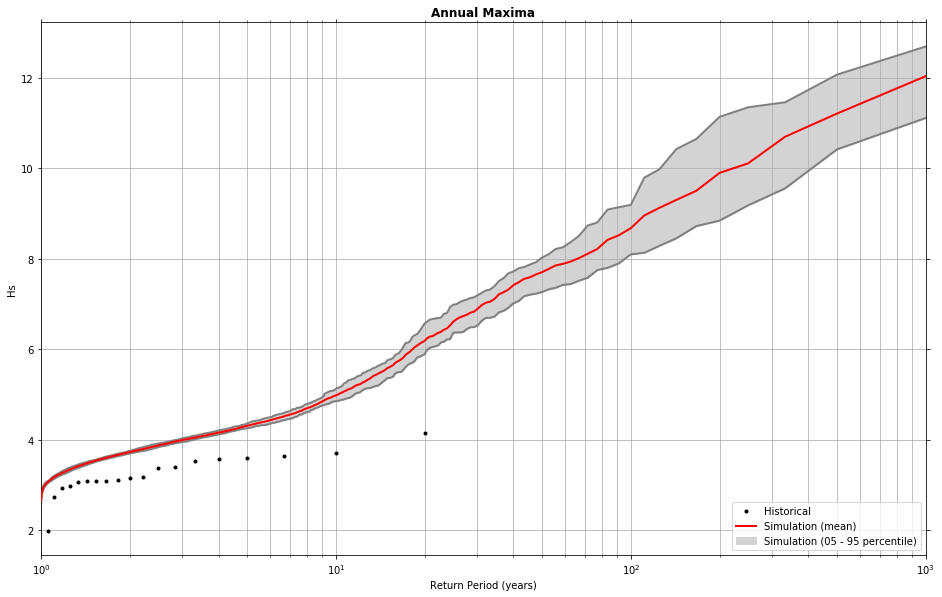

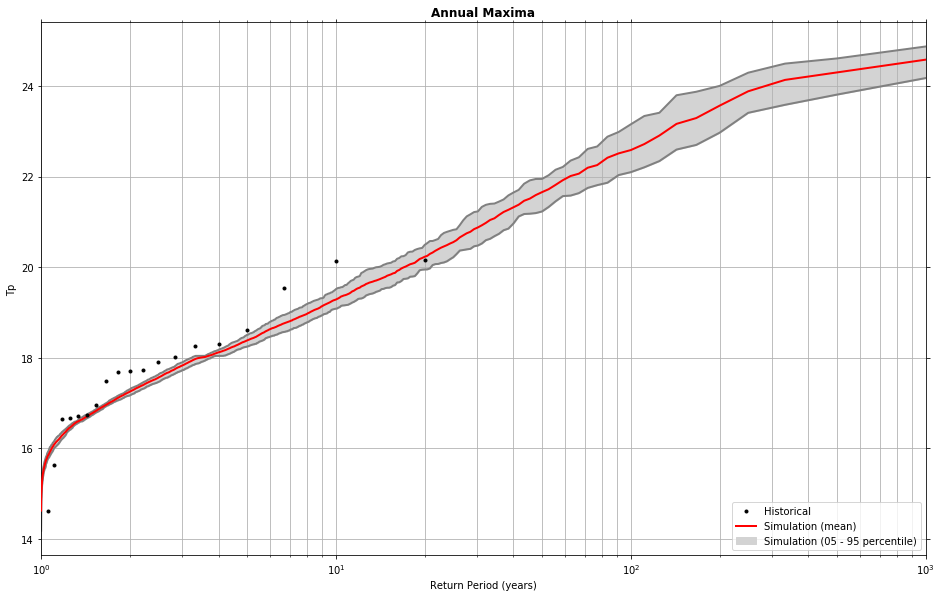

In [10]:
# compare historical and simulations reconstruction vars. annual maxima

vns = ['Hs', 'Tp']
for vn in vns:

    # calculate Annual Maxima values for historical and simulated data
    hist_A = WVS_HIST_rec[vn].groupby('time.year').max(dim='time')
    sim_A = xr.concat([x[vn].groupby('time.year').max(dim='time') for x in l_sims_rec], 'n_sim')

    # Return Period historical vs. simulations
    Plot_ReturnPeriodValidation(hist_A, sim_A);
    